In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../')
import psix_functions as px

## Psix: estimation of $Pr(\hat{\Psi} \mid \Psi, r, c)$

### Psix v1: deterministic estimation of probabilities

We make a deterministic estimate $Pr(\hat{\Psi} \mid \Psi, r, c)$. Since there is a disconnect between the splice junctions reads from which $\hat{\Psi}$ is calculated, and the mRNA molecules, we can round the observed $\hat{\Psi}$ to the closest possible value that is comparible with the total number of mRNA molecules available.

However, in practice, we apply a continuous approximation to make the calculation easier. The $\Psi_\xi$ score of the exons between the discrete calculation and the continuous approximation is highly correlated, particularly at the higher scoring exons (which are the ones we care about).

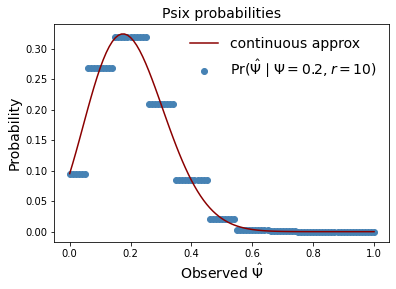

In [2]:
psix_v1_vector = [px.psix_v1_discrete(i, 0.2, 0.1, 10) for i in np.arange(0, 1.01, 0.01)]

plt.scatter(np.arange(0, 1.01, 0.01), psix_v1_vector, c='steelblue', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=10$)')
plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v1_continuous(i, 0.2, 0.1, 10) for i in np.arange(0, 1.01, 0.01)], 
         c='darkred', label='continuous approx')

plt.xlabel('Observed $\hat{\Psi}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Psix probabilities', fontsize=14)
plt.legend(fontsize=14, frameon=False)

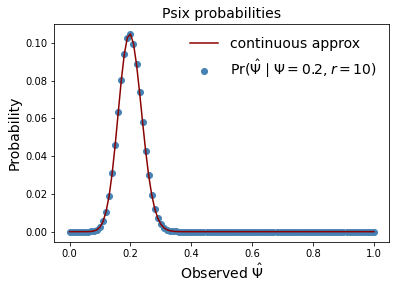

In [13]:
psix_v1_vector = [px.psix_v1_discrete(i, 0.2, 0.1, 100) for i in np.arange(0, 1.01, 0.01)]

plt.scatter(np.arange(0, 1.01, 0.01), psix_v1_vector, c='steelblue', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=10$)')
plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v1_continuous(i, 0.2, 0.1, 100) for i in np.arange(0, 1.01, 0.01)], 
         c='darkred', label='continuous approx')

plt.xlabel('Observed $\hat{\Psi}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Psix probabilities', fontsize=14)
plt.legend(fontsize=14, frameon=False)

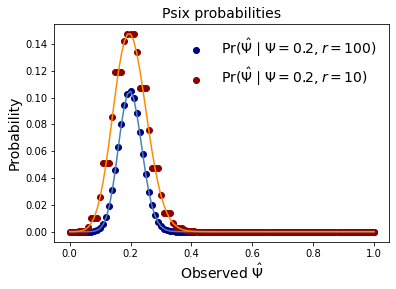

In [8]:
psix_v1_vector = [px.psix_v1_discrete(i, 0.2, 0.1, 100) for i in np.arange(0, 1.01, 0.01)]


plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v1_continuous(i, 0.2, 0.1, 100) for i in np.arange(0, 1.01, 0.01)], 
         c='steelblue')
plt.scatter(np.arange(0, 1.01, 0.01), psix_v1_vector, c='navy', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=100$)')

psix_v1_vector = [px.psix_v1_discrete(i, 0.2, 0.1, 50) for i in np.arange(0, 1.01, 0.01)]


plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v1_continuous(i, 0.2, 0.1, 50) for i in np.arange(0, 1.01, 0.01)], 
         c='darkorange')
plt.scatter(np.arange(0, 1.01, 0.01), psix_v1_vector, c='darkred', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=10$)')

plt.xlabel('Observed $\hat{\Psi}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Psix probabilities', fontsize=14)
plt.legend(fontsize=14, frameon=False)

Text(0, 0.7, 'Pearson r = 0.998')

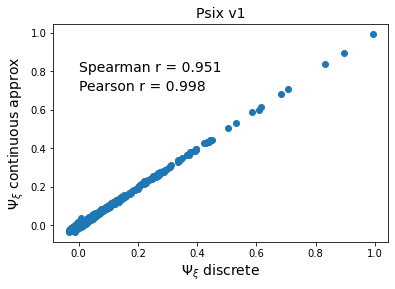

In [3]:
psix_scores = pd.read_csv('~/psix/development/test/psix.scores.txt', sep='\t', index_col=0)

plt.scatter(psix_scores.psix_v1_discrete, psix_scores.psix_v1)
plt.title('Psix v1', fontsize=14)
plt.xlabel(r'$\Psi_\xi$' + ' discrete', fontsize=14)
plt.ylabel(r'$\Psi_\xi$' + ' continuous approx', fontsize=14)
plt.text(0, 0.8, 
         'Spearman r = ' + str(round(spearmanr(psix_scores.psix_v1_discrete, psix_scores.psix_v1)[0], 3)), fontsize=14)
plt.text(0, 0.7, 
         'Pearson r = ' + str(round(pearsonr(psix_scores.psix_v1_discrete, psix_scores.psix_v1)[0], 3)), fontsize=14)

Text(0.5, 1.0, 'discrete vs continuous')

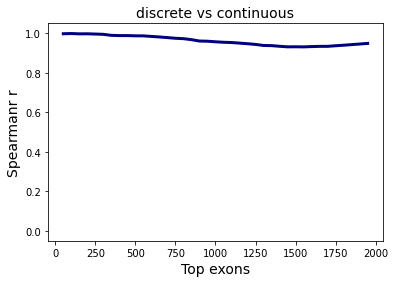

In [4]:
ordered_index = psix_scores.sort_values('psix_v1_discrete').index
spearman_list = [spearmanr(psix_scores.loc[ordered_index].psix_v1_discrete[-x:], 
                 psix_scores.loc[ordered_index].psix_v1[-x:])[0] for x in np.arange(50, 2000, 50)]

plt.plot(np.arange(50, 2000, 50), spearman_list, c='navy', linewidth=3)
plt.ylim(-0.05, 1.05)
plt.xlabel('Top exons', fontsize=14)
plt.ylabel('Spearmanr r', fontsize=14)
plt.title('discrete vs continuous', fontsize=14)

### Psix v2: Adding variance to $\Psi$

Here we add a normal distribution as a prior to $logit(\Psi)$.

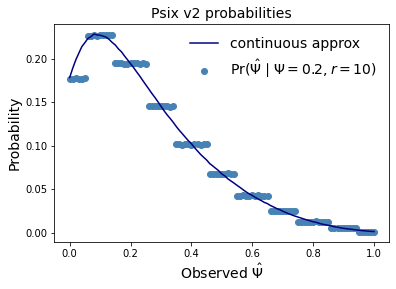

In [101]:
psix_v2_vector = [px.psix_v2_discrete(i, 0.2, 0.1, 10, psi_var=1, times=100000) for i in np.arange(0, 1.01, 0.01)]

plt.scatter(np.arange(0, 1.01, 0.01), psix_v2_vector, c='steelblue', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=10$)')
plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v2_continuous(i, 0.2, 0.1, 10, zvar = 1, capture_var = 0, 
                                       times=100000) for i in np.arange(0, 1.01, 0.01)], 
         c='navy', label='continuous approx')

plt.xlabel('Observed $\hat{\Psi}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Psix v2 probabilities', fontsize=14)
plt.legend(fontsize=14, frameon=False)

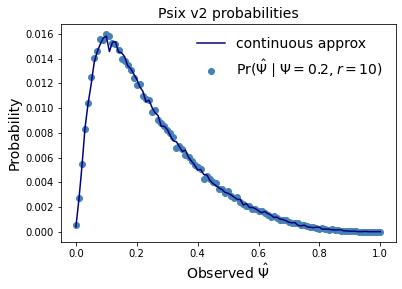

In [10]:
psix_v2_vector = [px.psix_v2_discrete(i, 0.2, 0.1, 200, psi_var=1, times=10000) for i in np.arange(0, 1.01, 0.01)]

plt.scatter(np.arange(0, 1.01, 0.01), psix_v2_vector, c='steelblue', label='Pr($\hat{\Psi} \mid \Psi =0.2, r=10$)')
plt.plot(np.arange(0, 1.01, 0.01),
    [px.psix_v2_continuous(i, 0.2, 0.1, 200, zvar = 1, capture_var = 0, 
                                       times=10000) for i in np.arange(0, 1.01, 0.01)], 
         c='navy', label='continuous approx')

plt.xlabel('Observed $\hat{\Psi}$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Psix v2 probabilities', fontsize=14)
plt.legend(fontsize=14, frameon=False)

Text(0, 0.5, '$\\Psi_\\xi$ continuous approx')

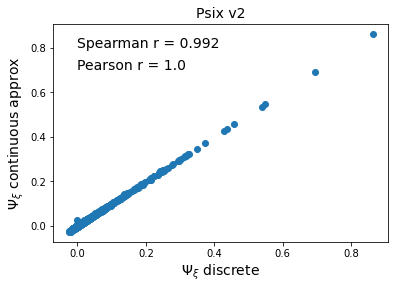

In [56]:
plt.scatter(psix_scores.psix_v2_discrete, psix_scores.psix_v2)
plt.text(0, 0.8, 
         'Spearman r = ' + str(round(spearmanr(psix_scores.psix_v2_discrete, psix_scores.psix_v2)[0], 3)), fontsize=14)
plt.text(0, 0.7, 
         'Pearson r = ' + str(round(pearsonr(psix_scores.psix_v2_discrete, psix_scores.psix_v2)[0], 3)), fontsize=14)

plt.title('Psix v2', fontsize=14)
plt.xlabel(r'$\Psi_\xi$' + ' discrete', fontsize=14)
plt.ylabel(r'$\Psi_\xi$' + ' continuous approx', fontsize=14)

Text(0.5, 1.0, 'Psix v2, discrete vs continuous')

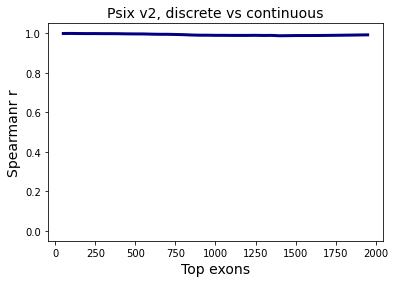

In [99]:
ordered_index = psix_scores.sort_values('psix_v2_discrete').index
spearman_list = [spearmanr(psix_scores.loc[ordered_index].psix_v2_discrete[-x:], 
                 psix_scores.loc[ordered_index].psix_v2[-x:])[0] for x in np.arange(50, 2000, 50)]

plt.plot(np.arange(50, 2000, 50), spearman_list, c='navy', linewidth=3)
plt.ylim(-0.05, 1.05)
plt.xlabel('Top exons', fontsize=14)
plt.ylabel('Spearmanr r', fontsize=14)
plt.title('Psix v2, discrete vs continuous', fontsize=14)

### Comparison of Psix v1 vs Psix v2

Text(0, 0.5, 'Psix v2, $\\Psi_\\xi$')

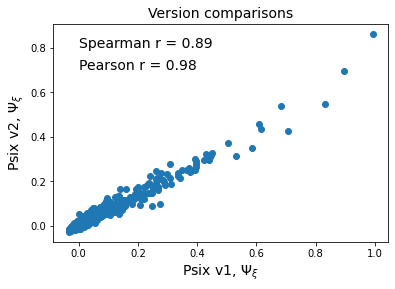

In [5]:
plt.scatter(psix_scores.psix_v1_discrete, psix_scores.psix_v2_discrete)
plt.text(0, 0.8, 
         'Spearman r = ' + str(round(spearmanr(psix_scores.psix_v1_discrete, 
                                               psix_scores.psix_v2_discrete)[0], 3)), fontsize=14)
plt.text(0, 0.7, 
         'Pearson r = ' + str(round(pearsonr(psix_scores.psix_v1_discrete, 
                                               psix_scores.psix_v2_discrete)[0], 3)), fontsize=14)

plt.title('Version comparisons', fontsize=14)
plt.xlabel(r'Psix v1, $\Psi_\xi$', fontsize=14)
plt.ylabel(r'Psix v2, $\Psi_\xi$', fontsize=14)

Text(0.5, 1.0, 'Version comparisons')

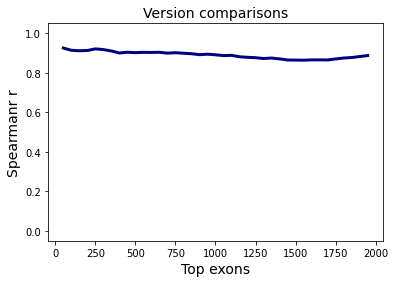

In [6]:
ordered_index = psix_scores.sort_values('psix_v1_discrete').index
spearman_list = [spearmanr(psix_scores.loc[ordered_index].psix_v1_discrete[-x:], 
                 psix_scores.loc[ordered_index].psix_v2_discrete[-x:])[0] for x in np.arange(50, 2000, 50)]

plt.plot(np.arange(50, 2000, 50), spearman_list, c='navy', linewidth=3)
plt.ylim(-0.05, 1.05)
plt.xlabel('Top exons', fontsize=14)
plt.ylabel('Spearmanr r', fontsize=14)
plt.title('Version comparisons', fontsize=14)

### Precision-recall using bulk data

In [7]:
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
kw_scores = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

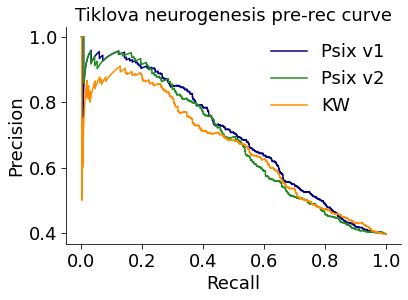

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# figsize(7, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = psix_scores.index
y1 = [1]*len(weyn_pos & exons) + [0]*len(weyn_neg & exons)
psix_v1_y = list(psix_scores.loc[weyn_pos & exons].psix_v1) + list(psix_scores.loc[weyn_neg & exons].psix_v1)
psix_v2_y = list(psix_scores.loc[weyn_pos & exons].psix_v2) + list(psix_scores.loc[weyn_neg & exons].psix_v2)
kw_y = list(kw_scores.loc[weyn_pos & exons].KW_score) + list(kw_scores.loc[weyn_neg & exons].KW_score)

pre1, rec1, thres1 = precision_recall_curve(y1, psix_v1_y)
pre2, rec2, thres2 = precision_recall_curve(y1, psix_v2_y)
pre3, rec3, thres3 = precision_recall_curve(y1, kw_y)

plt.plot(rec1, pre1, c='navy', label='Psix v1')
plt.plot(rec2, pre2, c='forestgreen', label='Psix v2')
plt.plot(rec3, pre3, c='darkorange', label='KW')

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
plt.title('Tiklova neurogenesis pre-rec curve', fontsize=18)
plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)